In [19]:
from pathlib import Path
import tensorflow as tf
import numpy as np
import statistics as st
import matplotlib.pyplot as plt

In [2]:
# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        print(f"✅ Using GPU: {gpus[0].name}")
        # Set mixed precision policy
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
    except RuntimeError as e:
        print("Failed to set GPU memory growth:", e)
else:
    print("No GPU found. Using CPU.")

# Set logging
tf.debugging.set_log_device_placement(False) # Set it to True to make sure the GPU is used

✅ Using GPU: /physical_device:GPU:0


In [3]:
dataset_path = "../processed_data/transformer_dataset"

# Load dataset without any transformations
raw_ds = tf.data.Dataset.load(dataset_path)

# Print dataset structure
print("Dataset element specification:", raw_ds.element_spec)

# Examine first 3 examples
print("\nFirst 3 examples:")
for i, example in enumerate(raw_ds.take(3)):
    # Each example contains 3 components:
    meta_tensor = example[0]  # Metadata (gameId, playId, split_id, firstFrameId)
    x_tensor = example[1]     # Input sequence (padded frames)
    y_tensor = example[2]     # Target vector
    
    print(f"\nExample {i+1}:")
    print("Metadata tensor:", meta_tensor)
    print(f"Metadata values: {meta_tensor.numpy()}")
    print(f"Input shape: {x_tensor.shape} | dtype: {x_tensor.dtype}")
    print(f"Target shape: {y_tensor.shape} | dtype: {y_tensor.dtype}")
    
    # First 5 elements of first frame's features
    print("First frame features (first 5 values):", x_tensor[0, :5].numpy())
    print("Target values (first 5):", y_tensor[:5].numpy())

I0000 00:00:1745605334.860878   64744 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Dataset element specification: (TensorSpec(shape=(4,), dtype=tf.int32, name=None), TensorSpec(shape=(100, 46), dtype=tf.float32, name=None), TensorSpec(shape=(46,), dtype=tf.float32, name=None))

First 3 examples:

Example 1:
Metadata tensor: tf.Tensor([2022091109       2481          2          1], shape=(4,), dtype=int32)
Metadata values: [2022091109       2481          2          1]
Input shape: (100, 46) | dtype: <dtype: 'float32'>
Target shape: (46,) | dtype: <dtype: 'float32'>
First frame features (first 5 values): [0. 0. 0. 0. 0.]
Target values (first 5): [0.14491667 0.6643527  0.14858334 0.30731708 0.12266666]

Example 2:
Metadata tensor: tf.Tensor([2022091109       2481          2          1], shape=(4,), dtype=int32)
Metadata values: [2022091109       2481          2          1]
Input shape: (100, 46) | dtype: <dtype: 'float32'>
Target shape: (46,) | dtype: <dtype: 'float32'>
First frame features (first 5 values): [0. 0. 0. 0. 0.]
Target values (first 5): [0.14316666 0.6733583

2025-04-25 19:22:15.203303: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
"""# Count examples per split
split_counts = {"train": 0, "val": 0, "test": 0}
for meta, *_ in raw_ds:
    split_id = meta[2].numpy()
    split_counts["train" if split_id==0 else "val" if split_id==1 else "test"] += 1
print(split_counts)"""

'# Count examples per split\nsplit_counts = {"train": 0, "val": 0, "test": 0}\nfor meta, *_ in raw_ds:\n    split_id = meta[2].numpy()\n    split_counts["train" if split_id==0 else "val" if split_id==1 else "test"] += 1\nprint(split_counts)'

In [5]:
"""game_splits = {}
for meta, *_ in raw_ds:
    game_id = meta[0].numpy()
    split_id = meta[2].numpy()
    if game_id in game_splits:
        assert game_splits[game_id] == split_id, f"Game {game_id} in multiple splits!"
    else:
        game_splits[game_id] = split_id"""

'game_splits = {}\nfor meta, *_ in raw_ds:\n    game_id = meta[0].numpy()\n    split_id = meta[2].numpy()\n    if game_id in game_splits:\n        assert game_splits[game_id] == split_id, f"Game {game_id} in multiple splits!"\n    else:\n        game_splits[game_id] = split_id'

In [6]:
"""from collections import Counter
seq_lengths = []
for meta, x, _ in raw_ds:
    seq_len = tf.math.count_nonzero(tf.reduce_any(x != 0, axis=1)).numpy()
    seq_lengths.append(seq_len)
print("Sequence length distribution:", Counter(seq_lengths))"""

'from collections import Counter\nseq_lengths = []\nfor meta, x, _ in raw_ds:\n    seq_len = tf.math.count_nonzero(tf.reduce_any(x != 0, axis=1)).numpy()\n    seq_lengths.append(seq_len)\nprint("Sequence length distribution:", Counter(seq_lengths))'

In [7]:
# Load the dataset and filter based on split_id
def filter_split(split_num):
    def _filter(meta, x, y):
        return tf.equal(meta[2], split_num)
    return _filter

# Split the dataset into train, val, test using the split_id
train_ds = raw_ds.filter(filter_split(0)).shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = raw_ds.filter(filter_split(1)).batch(64).prefetch(tf.data.AUTOTUNE)
test_ds = raw_ds.filter(filter_split(2)).batch(64).prefetch(tf.data.AUTOTUNE)

In [8]:
# Examine first 3 examples
print("\nFirst 3 examples:")
for i, example in enumerate(train_ds.take(3)):
    # Each example contains 3 components:
    meta_tensor = example[0]  # Metadata (gameId, playId, split_id, firstFrameId)
    x_tensor = example[1]     # Input sequence (padded frames)
    y_tensor = example[2]     # Target vector
    
    print(f"\nExample {i+1}:")
    print("Metadata tensor:", meta_tensor)
    print(f"Metadata values: {meta_tensor.numpy()}")
    print(f"Input shape: {x_tensor.shape} | dtype: {x_tensor.dtype}")
    print(f"Target shape: {y_tensor.shape} | dtype: {y_tensor.dtype}")
    
    # First 5 elements of first frame's features
    print("First frame features (first 5 values):", x_tensor[0, :-5].numpy())
    print("Target values (first 5):", y_tensor[:5].numpy())


First 3 examples:

Example 1:
Metadata tensor: tf.Tensor(
[[2022091806       2905          0          5]
 [2022091808        631          0         66]
 [2022091901       1290          0          1]
 [2022091806       3030          0          2]
 [2022091112       2886          0         67]
 [2022091112       2886          0         55]
 [2022091901       3088          0         12]
 [2022091112       2886          0          1]
 [2022091811        835          0         12]
 [2022091102        942          0          1]
 [2022091500        257          0         20]
 [2022091104       4372          0          1]
 [2022091104       3754          0          1]
 [2022091806       2905          0          1]
 [2022091102        942          0         33]
 [2022091901       1290          0          1]
 [2022091901       3088          0         10]
 [2022091110       1232          0          1]
 [2022091110       3821          0          1]
 [2022091811        835          0          1]
 

2025-04-25 19:22:18.821016: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
print("Dataset cardinality:",
      tf.data.experimental.cardinality(raw_ds).numpy())   # should now print a number


Dataset cardinality: 592871


In [10]:
def drop_meta(meta, x, y):
    return x, y

train_ds = (raw_ds
            .filter(filter_split(0))
            .map(drop_meta, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(4096)
            .batch(64)
            .prefetch(tf.data.AUTOTUNE))

val_ds   = (raw_ds
            .filter(filter_split(1))
            .map(drop_meta, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(64)
            .prefetch(tf.data.AUTOTUNE))

test_ds  = (raw_ds
            .filter(filter_split(2))
            .map(drop_meta, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(64)
            .prefetch(tf.data.AUTOTUNE))

# Take one batch from the dataset
for x_batch, y_batch in train_ds.take(1):
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)

for x_batch, y_batch in val_ds.take(1):
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)

for x_batch, y_batch in test_ds.take(1):
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)

x_batch shape: (64, 100, 46)
y_batch shape: (64, 46)
x_batch shape: (64, 100, 46)
y_batch shape: (64, 46)
x_batch shape: (64, 100, 46)
y_batch shape: (64, 46)


2025-04-25 19:22:23.005823: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
dataset_path = "../processed_data/transformer_dataset"

# Load dataset without any transformations
raw_ds = tf.data.Dataset.load(dataset_path)

# Print dataset structure
print("Dataset element specification:", raw_ds.element_spec)

# Examine first 3 examples
print("\nFirst 3 examples:")
for i, example in enumerate(raw_ds.take(3)):
    # Each example contains 3 components:
    meta_tensor = example[0]  # Metadata (gameId, playId, split_id, firstFrameId)
    x_tensor = example[1]     # Input sequence (padded frames)
    y_tensor = example[2]     # Target vector
    
    print(f"\nExample {i+1}:")
    print("Metadata tensor:", meta_tensor)
    print(f"Metadata values: {meta_tensor.numpy()}")
    print(f"Input shape: {x_tensor.shape} | dtype: {x_tensor.dtype}")
    print(f"Target shape: {y_tensor.shape} | dtype: {y_tensor.dtype}")
    
    # First 5 elements of first frame's features
    print("First frame features (first 5 values):", x_tensor[0, :5].numpy())
    print("Target values (first 5):", y_tensor[:5].numpy())

Dataset element specification: (TensorSpec(shape=(4,), dtype=tf.int32, name=None), TensorSpec(shape=(100, 46), dtype=tf.float32, name=None), TensorSpec(shape=(46,), dtype=tf.float32, name=None))

First 3 examples:

Example 1:
Metadata tensor: tf.Tensor([2022091109       2481          2          1], shape=(4,), dtype=int32)
Metadata values: [2022091109       2481          2          1]
Input shape: (100, 46) | dtype: <dtype: 'float32'>
Target shape: (46,) | dtype: <dtype: 'float32'>
First frame features (first 5 values): [0. 0. 0. 0. 0.]
Target values (first 5): [0.14491667 0.6643527  0.14858334 0.30731708 0.12266666]

Example 2:
Metadata tensor: tf.Tensor([2022091109       2481          2          1], shape=(4,), dtype=int32)
Metadata values: [2022091109       2481          2          1]
Input shape: (100, 46) | dtype: <dtype: 'float32'>
Target shape: (46,) | dtype: <dtype: 'float32'>
First frame features (first 5 values): [0. 0. 0. 0. 0.]
Target values (first 5): [0.14316666 0.6733583

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

NUM_FEATS = 46          # x,y for 23 entities
MAX_LEN  = 100          # same value you used in dataset builder
D_MODEL  = 128          # transformer hidden size
N_HEADS  = 4
N_LAYERS = 4
D_FF     = 512
DROPOUT  = 0.1

In [13]:
# ╔═══════════════════╗
# ║ 2. Positional enc ║  (learnable 1‑D embedding)
# ╚═══════════════════╝
class PositionalEncoding(layers.Layer):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pos_emb = self.add_weight(
            name="pos_emb",
            shape=(max_len, d_model),
            initializer="uniform",
            trainable=True,
        )

    def call(self, x):
        return x + self.pos_emb


In [14]:
# ╔═══════════════════════════╗
# ║ 3. Padding‑mask function  ║
# ╚═══════════════════════════╝
class PaddingMask(layers.Layer):
    def call(self, x):
        # x:  (B, T, F) — zero‐padded on the left
        pad = tf.reduce_all(tf.equal(x, 0.0), axis=-1)      # → (B, T)
        # reshape to (B, 1, 1, T) for MultiHeadAttention
        return pad[:, tf.newaxis, tf.newaxis, :]



In [15]:
# ╔════════════════════════╗
# ║ 4. Transformer encoder ║
# ╚════════════════════════╝
def transformer_block(d_model, n_heads, d_ff, dropout):
    inputs   = layers.Input(shape=(None, d_model))
    padding  = layers.Input(shape=(1,1,None), dtype=tf.bool)  # mask

    x = layers.MultiHeadAttention(
        num_heads=n_heads, key_dim=d_model//n_heads, dropout=dropout
    )(inputs, inputs, attention_mask=padding)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(inputs + x)

    y = layers.Dense(d_ff, activation="relu")(x)
    y = layers.Dense(d_model)(y)
    y = layers.Dropout(dropout)(y)
    y = layers.LayerNormalization(epsilon=1e-6)(x + y)

    return keras.Model([inputs, padding], y)


In [ ]:
# ╔════════════════════════════════╗
# ║ 5. End‑to‑end prediction model ║
# ╚════════════════════════════════╝
def build_model(
    num_feats=NUM_FEATS,
    max_len=MAX_LEN,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    d_ff=D_FF,
    dropout=DROPOUT,
):
    seq_in  = layers.Input(shape=(max_len, num_feats), name="sequence")   # (B,T,F)

    # Linear projection to d_model
    x = layers.Dense(d_model)(seq_in)

    # Add learnable positional encodings
    x = PositionalEncoding(max_len, d_model)(x)

    # Build padding mask once
    pad_mask = PaddingMask()(seq_in)

    # Stack encoder layers
    for _ in range(n_layers):
        x = transformer_block(d_model, n_heads, d_ff, dropout)([x, pad_mask])

    # We need the hidden state that corresponds to *frame t* (the last row)
    # – that is always index -1 thanks to left padding.
    h_t = layers.Lambda(lambda t: t[:, -1])(x)          # (B, D)

    # Regress the 46 co‑ordinates
    # out = layers.Dense(num_feats, name="pred_xy")(h_t)
    out = layers.Dense(num_feats, dtype='float32', name="pred_xy")(h_t) # This is important for mixed precision (training on GPU)


    return keras.Model(seq_in, out, name="NFL_Frame_Predictor")

model = build_model()
model.summary()

Model: "NFL_Frame_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 100, 46)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 100, 46)   │          0 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100, 128)  │      6,016 │ cast[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 100, 46)   │          0 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 100, 128)  │     12,800 │ dense[0][0]       │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, 1, 1, 100) │          0 │ cast_1[0][0]      │
│ (PaddingMask)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 100, 128)  │    198,272 │ positional_encod… │
│ (Functional)        │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 100, 128)  │    198,272 │ functional[0][0], │
│ (Functional)        │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 100, 128)  │    198,272 │ functional_1[0][… │
│ (Functional)        │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 100, 128)  │    198,272 │ functional_2[0][… │
│ (Functional)        │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ functional_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_10 (Cast)      │ (None, 128)       │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pred_xy (Dense)     │ (None, 46)        │      5,934 │ cast_10[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 817,838 (3.12 MB)

 Trainable params: 817,838 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time

# ╔════════════════════╗
# ║ 6. Compile & train ║
# ╚════════════════════╝

# ── 1)  Make sure we have a place to put checkpoints ─────────────────
WEIGHT_DIR = Path("../weights")
WEIGHT_DIR.mkdir(parents=True, exist_ok=True)

ckpt_cb = keras.callbacks.ModelCheckpoint(
    filepath=(WEIGHT_DIR /
            #   "epoch_{epoch:03d}-val{val_loss:.4f}.keras").as_posix(),
              "epoch_{epoch:03d}-val{val_loss:.4f}.weights.h5").as_posix(),
    monitor="val_loss",
    save_best_only=False,      # save every epoch → “periodic” archive
    save_weights_only=True,    # just the weights, not optimizer state
    verbose=0,
)

# ── 2)  Early-stopping ───────────────────────────────────────────────
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1,
)

# ── 3)  Compile the model ────────────────────────────────────────────
LR = 1e-4
model.compile(
    optimizer=keras.optimizers.Adam(LR),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError()],
)

# ── 4)  Fit – stop early, save weights each epoch ────────────────────
EPOCHS = 15   # high ceiling; early-stop decides real count
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stop, ckpt_cb],
    verbose=1,
)

# optional: evaluate on test set after training
test_loss, test_mae = model.evaluate(test_ds, verbose=1)
print(f"\n✅  Test MSE: {test_loss:.5f}   |   Test MAE: {test_mae:.5f}")


Epoch 1/15


I0000 00:00:1745605351.544888   64817 service.cc:148] XLA service 0x7f33600087a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745605351.544925   64817 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-04-25 19:22:31.689220: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745605352.502585   64817 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-25 19:22:34.091910: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6_0', 104 bytes spill stores, 104 bytes spill loads

2025-04-25 19:22:36.727296: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_29', 48 bytes 

   6988/Unknown 310s 41ms/step - loss: 0.0307 - mean_absolute_error: 0.1030

2025-04-25 19:27:35.763751: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 12 bytes spill stores, 12 bytes spill loads

2025-04-25 19:27:36.432894: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 32 bytes spill stores, 32 bytes spill loads

2025-04-25 19:27:36.576041: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 20 bytes spill stores, 20 bytes spill loads

2025-04-25 19:27:37.230365: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27', 32 bytes spill stores, 32 bytes spill loads



   6993/Unknown 320s 43ms/step - loss: 0.0306 - mean_absolute_error: 0.1030

2025-04-25 19:27:43.979597: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/home/juanbsosa/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-04-25 19:27:45.520918: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 132 bytes spill stores, 132 bytes spill loads

2025-04-25 19:27:45.595243: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 200

6993/6993 ━━━━━━━━━━━━━━━━━━━━ 599s 83ms/step - loss: 0.0306 - mean_absolute_error: 0.1030 - val_loss: 4.6110e-04 - val_mean_absolute_error: 0.0164
Epoch 2/15
6993/6993 ━━━━━━━━━━━━━━━━━━━━ 553s 79ms/step - loss: 7.1819e-04 - mean_absolute_error: 0.0204 - val_loss: 2.7995e-04 - val_mean_absolute_error: 0.0132
Epoch 3/15
6989/6993 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.3174e-04 - mean_absolute_error: 0.0139

2025-04-25 19:46:25.558464: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-25 19:50:46.827922: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 761195700543843345
2025-04-25 19:50:46.827971: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14578956645690315843


6993/6993 ━━━━━━━━━━━━━━━━━━━━ 551s 78ms/step - loss: 3.3171e-04 - mean_absolute_error: 0.0139 - val_loss: 1.4931e-04 - val_mean_absolute_error: 0.0096
Epoch 4/15
6991/6993 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.0942e-04 - mean_absolute_error: 0.0111

2025-04-25 19:59:55.283049: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 761195700543843345
2025-04-25 19:59:55.283103: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14578956645690315843


6993/6993 ━━━━━━━━━━━━━━━━━━━━ 548s 78ms/step - loss: 2.0942e-04 - mean_absolute_error: 0.0111 - val_loss: 9.7101e-05 - val_mean_absolute_error: 0.0080
Epoch 5/15
6991/6993 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.5119e-04 - mean_absolute_error: 0.0094

2025-04-25 20:09:07.717425: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 761195700543843345
2025-04-25 20:09:07.717476: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14578956645690315843


6993/6993 ━━━━━━━━━━━━━━━━━━━━ 552s 79ms/step - loss: 1.5119e-04 - mean_absolute_error: 0.0094 - val_loss: 7.4390e-05 - val_mean_absolute_error: 0.0070
Epoch 6/15
6992/6993 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.1485e-04 - mean_absolute_error: 0.0082

2025-04-25 20:18:19.043498: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 761195700543843345
2025-04-25 20:18:19.043545: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14578956645690315843


6993/6993 ━━━━━━━━━━━━━━━━━━━━ 551s 78ms/step - loss: 1.1485e-04 - mean_absolute_error: 0.0082 - val_loss: 4.4977e-05 - val_mean_absolute_error: 0.0051
Epoch 7/15
6989/6993 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 8.8897e-05 - mean_absolute_error: 0.0072

2025-04-25 20:23:06.690234: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-25 20:27:29.537339: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 761195700543843345
2025-04-25 20:27:29.537390: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14578956645690315843


6993/6993 ━━━━━━━━━━━━━━━━━━━━ 550s 78ms/step - loss: 8.8893e-05 - mean_absolute_error: 0.0072 - val_loss: 4.6056e-05 - val_mean_absolute_error: 0.0053
Epoch 8/15
6992/6993 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.1375e-05 - mean_absolute_error: 0.0064

2025-04-25 20:36:39.733588: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 761195700543843345
2025-04-25 20:36:39.733646: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14578956645690315843


6993/6993 ━━━━━━━━━━━━━━━━━━━━ 550s 78ms/step - loss: 7.1373e-05 - mean_absolute_error: 0.0064 - val_loss: 2.5112e-05 - val_mean_absolute_error: 0.0038
Epoch 9/15
6992/6993 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.7577e-05 - mean_absolute_error: 0.0058

2025-04-25 20:45:49.173566: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 761195700543843345
2025-04-25 20:45:49.173611: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14578956645690315843


6993/6993 ━━━━━━━━━━━━━━━━━━━━ 549s 78ms/step - loss: 5.7576e-05 - mean_absolute_error: 0.0058 - val_loss: 5.8776e-05 - val_mean_absolute_error: 0.0060
Epoch 10/15
6993/6993 ━━━━━━━━━━━━━━━━━━━━ 551s 78ms/step - loss: 4.7977e-05 - mean_absolute_error: 0.0053 - val_loss: 2.1763e-05 - val_mean_absolute_error: 0.0034
Epoch 11/15
6990/6993 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.0617e-05 - mean_absolute_error: 0.0048

2025-04-25 21:04:09.422619: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 761195700543843345
2025-04-25 21:04:09.422669: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14578956645690315843


6993/6993 ━━━━━━━━━━━━━━━━━━━━ 549s 78ms/step - loss: 4.0616e-05 - mean_absolute_error: 0.0048 - val_loss: 2.1151e-05 - val_mean_absolute_error: 0.0034
Epoch 12/15
6990/6993 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.5393e-05 - mean_absolute_error: 0.0045

2025-04-25 21:13:18.355136: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 761195700543843345
2025-04-25 21:13:18.355180: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14578956645690315843


6993/6993 ━━━━━━━━━━━━━━━━━━━━ 549s 78ms/step - loss: 3.5393e-05 - mean_absolute_error: 0.0045 - val_loss: 1.7882e-05 - val_mean_absolute_error: 0.0030
Epoch 13/15
6988/6993 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.0409e-05 - mean_absolute_error: 0.0042

2025-04-25 21:22:28.258838: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 761195700543843345
2025-04-25 21:22:28.258887: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14578956645690315843


6993/6993 ━━━━━━━━━━━━━━━━━━━━ 550s 78ms/step - loss: 3.0409e-05 - mean_absolute_error: 0.0042 - val_loss: 1.9668e-05 - val_mean_absolute_error: 0.0032
Epoch 14/15
6990/6993 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.7861e-05 - mean_absolute_error: 0.0040

2025-04-25 21:31:42.861701: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 761195700543843345
2025-04-25 21:31:42.861773: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14578956645690315843


6993/6993 ━━━━━━━━━━━━━━━━━━━━ 555s 79ms/step - loss: 2.7860e-05 - mean_absolute_error: 0.0040 - val_loss: 2.2100e-05 - val_mean_absolute_error: 0.0035
Epoch 15/15
6989/6993 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.4660e-05 - mean_absolute_error: 0.0038

2025-04-25 21:36:29.968585: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-25 21:40:53.349280: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 761195700543843345
2025-04-25 21:40:53.349321: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14578956645690315843


6993/6993 ━━━━━━━━━━━━━━━━━━━━ 550s 78ms/step - loss: 2.4660e-05 - mean_absolute_error: 0.0038 - val_loss: 1.9976e-05 - val_mean_absolute_error: 0.0033
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 12.
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 267s 190ms/step - loss: 1.6967e-05 - mean_absolute_error: 0.0030

✅  Test MSE: 0.00002   |   Test MAE: 0.00303


2025-04-25 21:45:20.278538: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 761195700543843345
2025-04-25 21:45:20.278579: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14578956645690315843


In [18]:
# ╔═══════════════╗
# ║ 7. Evaluation ║
# ╚═══════════════╝
# Simple end‑to‑end evaluation on a held‑out batch
for X_batch, y_batch in val_ds.take(1):
    y_pred = model(X_batch)
    mse = tf.reduce_mean(tf.square(y_pred - y_batch))
    print("Validation MSE (batch):", mse.numpy())


2025-04-25 21:45:20.741125: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Validation MSE (batch): 4.876001e-06


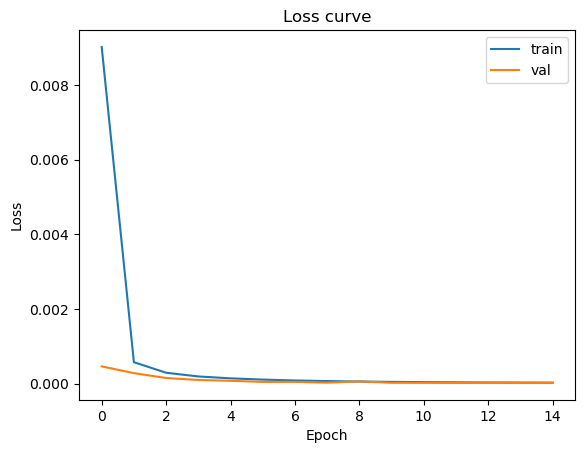

In [20]:
# ╔════════════════╗
# ║ 8. Curves Plot ║
# ╚════════════════╝
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()